In [1]:
import glob
import time
import warnings

from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.nddata import NDData
from astropy.stats import sigma_clipped_stats, gaussian_sigma_to_fwhm
from astropy.table import QTable
from astropy.time import Time
from astropy.utils.exceptions import AstropyUserWarning
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from photutils import extract_stars, EPSFBuilder, EPSFModel
from photutils import DBSCANGroup, MMMBackground, BasicPSFPhotometry
from photutils import CircularAperture, aperture_photometry

In [2]:
stars_tbl = QTable.read('gaia_catalog.ecsv')
epsf_data = fits.getdata('epsf.fits')
epsf = EPSFModel(epsf_data, oversampling=4.)

In [3]:
star_skycoord = SkyCoord(92.126041, 24.441154, unit='deg', frame='icrs')

In [4]:
times = []
psf_fluxes = []
psf_uncertainties = []
aperture_fluxes = []
residual_fluxes = []

warnings.filterwarnings('ignore', category=AstropyUserWarning)

filepaths = sorted(glob.glob('superstampImages/*'))
for i, filepath in enumerate(filepaths):
    if 'bjd2456768.8805' in filepath:
        continue
        
    start_time = time.time()
    
    hdulist = fits.open(filepath)
    data = hdulist[0].data
    header = hdulist[0].header
    wcs = WCS(header)
    times.append(header['MIDTIME'])
    
    mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.)
    bkg = 2.5 * median_val - 1.5 * mean_val
    data -= bkg
    
    grouper = DBSCANGroup(gaussian_sigma_to_fwhm)
    
    epsf.normalization_correction = 1.0 / (epsf.oversampling[0] ** 2)
    psf_model = epsf
    
    bkg_est = MMMBackground()
    fitter = LevMarLSQFitter()
   
    psf_phot = BasicPSFPhotometry(group_maker=grouper, bkg_estimator=bkg_est,
                                  psf_model=psf_model, fitter=fitter, fitshape=(7, 7),
                                  aperture_radius=3)
    
    xpos, ypos = wcs.world_to_pixel(star_skycoord)
    star_pos = QTable(names=['x_0', 'y_0'], data=[[xpos], [ypos]])

    psf_tbl = psf_phot(data, init_guesses=star_pos)
    psf_fluxes.append(psf_tbl['flux_fit'])
    psf_uncertainties.append(psf_tbl['flux_unc'])
                    
    # perform aperture photometry on the residuals to account for what the model missed
    position = (psf_tbl['x_fit'][0], psf_tbl['y_fit'][0])
    aperture = CircularAperture(position, r=3.)
    
    aper_tbl = aperture_photometry(data, aperture)
    aperture_fluxes.append(aper_tbl['aperture_sum'])
    
    residual_image_star1 = psf_phot.get_residual_image()
    residual_aper_tbl = aperture_photometry(residual_image_star1, aperture)
    residual_fluxes.append(residual_aper_tbl['aperture_sum'])
    
    print(i, time.time() - start_time)

0 0.4913289546966553
1 0.20438289642333984
2 0.17590808868408203
3 0.16813182830810547
4 0.17196011543273926
5 0.16874384880065918
6 0.17125916481018066
7 0.17469191551208496
8 0.16911625862121582
9 0.1748039722442627
10 0.1799759864807129
11 0.17932891845703125
12 0.16721391677856445
13 0.17599797248840332
14 0.17039012908935547
15 0.17148900032043457
16 0.2097458839416504
17 0.17715001106262207
18 0.1731729507446289
19 0.17099595069885254
20 0.17483901977539062
21 0.18090200424194336
22 0.1756269931793213
23 0.17696523666381836
24 0.17491984367370605
25 0.1736462116241455
26 0.1718740463256836
27 0.17001605033874512
28 0.17791509628295898
29 0.17102313041687012
30 0.18595409393310547
31 0.16848516464233398
32 0.17123198509216309
33 0.1673722267150879
34 0.17046594619750977
35 0.17197394371032715
36 0.17160296440124512
37 0.17098379135131836
38 0.17602300643920898
39 0.17415499687194824
40 0.1914057731628418
41 0.1655738353729248
42 0.17151689529418945
43 0.17095398902893066
44 0.1746

In [5]:
times = Time(times, format='jd', scale='tcb')
psf_fluxes = np.array(psf_fluxes)
psf_uncertainties = np.array(psf_uncertainties)
aperture_fluxes = np.array(aperture_fluxes)
residual_fluxes = np.array(residual_fluxes)

(0.96, 1.05)

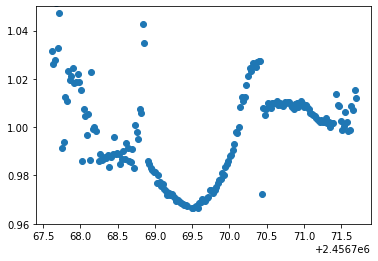

In [6]:
plt.plot(times.jd, psf_fluxes / np.median(psf_fluxes), 'o')
plt.ylim(0.96, 1.05)

(0.96, 1.05)

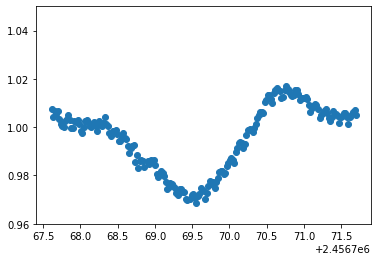

In [7]:
plt.plot(times.jd, aperture_fluxes / np.median(aperture_fluxes), 'o')
plt.ylim(0.96, 1.05)

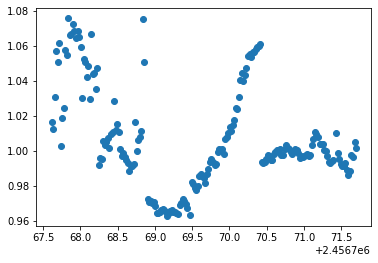

In [8]:
val = psf_fluxes + residual_fluxes
plt.plot(times.jd, val / np.median(val), 'o')

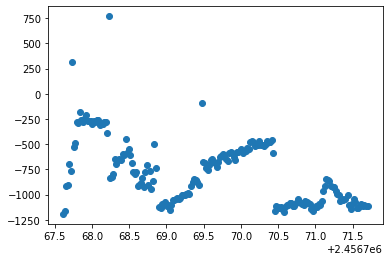

In [9]:
plt.plot(times.jd, residual_fluxes, 'o')